<a href="https://colab.research.google.com/github/BuddGao/DL-Competition/blob/main/Competition_decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!unzip "drive/MyDrive/DL_Project/Train.zip" -d  "drive/MyDrive/DL_Project/"

In [10]:
#!unzip "drive/MyDrive/DL_Project/Val Blind.zip" -d  "drive/MyDrive/DL_Project/"
!/opt/bin/nvidia-smi

/bin/bash: /opt/bin/nvidia-smi: No such file or directory


In [3]:
## preprocess data
## create custom data class
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.model_selection import KFold
import os
import torch
import pandas as pd
from skimage import io, transform

import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2
from PIL import Image
import glob

class CovidDataset(Dataset):
    """Covid CT dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.label_data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        ## you can apply custom transformation on the image for data augmentation
        self.transform = transform

    def __len__(self):
        return len(self.label_data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.label_data.iloc[idx, 0])
        image = io.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
        image = torchvision.transforms.functional.to_tensor(image)
        p = self.label_data.iloc[idx, 1]
        subject_num = self.label_data.iloc[idx, 2]
        sample = {'image': image, 'percentage': p, 'subject': subject_num, 'img_name':img_name}

        # should be only applied on image, not percentage or subject #
        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
class CovidTestDataset(Dataset):
    """Covid CT TEST dataset."""

    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.root_dir = root_dir
        self.image_list = []
        for filename in glob.glob(self.root_dir+"/*.png"): #assuming png
          self.image_list.append(filename)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.image_list[idx]
        image = io.imread(img_name)
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)
        image = torchvision.transforms.functional.to_tensor(image)
        sample = {'image': image, 'img_name':img_name}

        return sample

In [5]:
import torchvision
covid_dataset_train_val = CovidDataset(csv_file='drive/MyDrive/DL_Project/Train.csv',
                                    root_dir='drive/MyDrive/DL_Project/Train'
                                    #, transform = transforms.Compose([
                                    #           Rescale(256),
                                    #           RandomCrop(224),
                                    #           ToTensor()
                                    #       ])
                                    )

covid_dataset_test = CovidTestDataset(root_dir='drive/MyDrive/DL_Project/Val')

FileNotFoundError: ignored

In [15]:
## plot training example
for i in range(len(covid_dataset_train_val)):
    sample = covid_dataset_train_val[i]
    print(i, sample['image'].shape, sample['percentage'], sample['subject'])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'].numpy().transpose(1,2,0))
    if i == 3:
        plt.show()
        break

NameError: ignored

In [16]:
## plot test examples
for i in range(len(covid_dataset_test)):
    sample = covid_dataset_test[i]
    print(i, sample['image'].shape, sample['img_name'])
    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    plt.imshow(sample['image'].numpy().transpose(1,2,0))
    if i == 3:
        plt.show()
        break

NameError: ignored

In [17]:
# generate the index of subjects for k-fold cross validation
def generate_index(dat,k):
    
    Y = list(range(0,dat[-1]['subject']+1))
    kf = KFold(n_splits=k, shuffle=True)

    n = len(Y)
    index = {'train_index':[],
             'val_index':[]}

    for train_index, val_index in kf.split(np.zeros(n), Y):
        index['train_index'].append(train_index)
        index['val_index'].append(val_index)
        
    
    return pd.DataFrame(index['train_index']).T,pd.DataFrame(index['val_index']).T

In [18]:
# get links form subjects to images
df = pd.read_csv('drive/MyDrive/DL_Project/Train.csv')
subtoimage = []
le = []
for sub in range(0,covid_dataset_train_val[-1]['subject']+1):
  subtoimage.append(df[df['0'] == sub].index.tolist())
  le.append(len(df[df['0'] == sub].index.tolist()))

FileNotFoundError: ignored

In [19]:
# get images' index form subjects' index
def get_image_index(subindex,subtoimage):
    imageindex = []
    for sub in range(0,len(subindex)):
        imageindex.extend(subtoimage[subindex[sub]])
    return imageindex

In [6]:
## use imagenet pretrained model
## let's start with resnet34
!pip install pretrainedmodels

In [7]:
import pretrainedmodels
pretrainedmodels.__dict__


{'__builtins__': {'ArithmeticError': ArithmeticError,
  'AssertionError': AssertionError,
  'AttributeError': AttributeError,
  'BaseException': BaseException,
  'BlockingIOError': BlockingIOError,
  'BrokenPipeError': BrokenPipeError,
  'BufferError': BufferError,
  'BytesWarning': BytesWarning,
  'ChildProcessError': ChildProcessError,
  'ConnectionAbortedError': ConnectionAbortedError,
  'ConnectionError': ConnectionError,
  'ConnectionRefusedError': ConnectionRefusedError,
  'ConnectionResetError': ConnectionResetError,
  'DeprecationWarning': DeprecationWarning,
  'EOFError': EOFError,
  'Ellipsis': Ellipsis,
  'EnvironmentError': OSError,
  'Exception': Exception,
  'False': False,
  'FileExistsError': FileExistsError,
  'FileNotFoundError': FileNotFoundError,
  'FloatingPointError': FloatingPointError,
  'FutureWarning': FutureWarning,
  'GeneratorExit': GeneratorExit,
  'IOError': OSError,
  'ImportError': ImportError,
  'ImportWarning': ImportWarning,
  'IndentationError': Ind

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [9]:
import pretrainedmodels
#For model building
import torch
from torch import nn, optim
import torchvision
from torch.nn import functional as F

class CNN1(nn.Module):
    def __init__(self, pretrained=True):
        super(CNN1, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained=None)
        #self.fc1 = nn.Linear(512, 256)
        self.conv1 = nn.Conv2d(512, 128, (5,5), stride=1, padding =0)
        self.conv2 = nn.Conv2d(128, 32, (5,5), stride=1, padding =0)
        self.dropout = nn.Dropout(p=0.5)
        self.conv3 = nn.Conv2d(32, 8, (5,5), stride=1, padding =0)
        self.fc1 = nn.Linear(128, 1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        #x = F.adaptive_avg_pool2d(x) #.reshape(bs, -1)
        #x = F.relu(self.fc1(x))
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(F.relu(x))
        #print(x.size()) # [8, 8, 4, 4]
        label = self.fc1(x.reshape(bs, -1))  # [8, 128]
        return label

In [ ]:
class CNN11(nn.Module):
    def __init__(self, pretrained=True):
        super(CNN11, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained=None)
        #self.fc1 = nn.Linear(512, 256)
        self.pool1 = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc1 = nn.Linear(in_features=512, out_features=1, bias=True)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        x = self.pool1(x)
        label = self.fc1(x.reshape(bs, -1))  # [8, 128]
        return label

In [ ]:
class CNN2(nn.Module):
    def __init__(self, pretrained=True):
        super(CNN2, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet18"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet18"](pretrained=None)
        #self.fc1 = nn.Linear(512, 256)
        self.conv1 = nn.Conv2d(512, 128, (5,5), stride=1, padding =0)
        self.conv2 = nn.Conv2d(128, 32, (5,5), stride=1, padding =0)
        self.dropout = nn.Dropout(p=0.5)
        self.conv3 = nn.Conv2d(32, 8, (5,5), stride=1, padding =0)
        self.fc1 = nn.Linear(128, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        #x = F.adaptive_avg_pool2d(x) #.reshape(bs, -1)
        #x = F.relu(self.fc1(x))
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(F.relu(x))
        # print(x.size()) # [8, 8, 4, 4]
        label = self.fc1(x.reshape(bs, -1))  # [8, 128]
        label = self.fc2(label)
        label = self.fc3(label)
        return label

In [ ]:
# reference: https://github.com/mr7495/COVID-CT-Code/blob/master/COVID_Train%26Validation.ipynb
class CNN3(nn.Module):
    def __init__(self, pretrained=True,freeze=True):
        super(CNN3, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet50"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet50"](pretrained=None)
        if freeze is True:
            for param in self.model.parameters():
              param.requires_grad = False
        #self.fc1 = nn.Linear(512, 256)
        self.conv1 = nn.Conv2d(512, 128, (5,5), stride=1, padding =0)
        self.conv2 = nn.Conv2d(128, 32, (5,5), stride=1, padding =0)
        self.dropout = nn.Dropout(p=0.5)
        self.conv3 = nn.Conv2d(32, 8, (5,5), stride=1, padding =0)
        self.fc1 = nn.Linear(128, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        #x = F.adaptive_avg_pool2d(x) #.reshape(bs, -1)
        #x = F.relu(self.fc1(x))
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(F.relu(x))
        # print(x.size()) # [8, 8, 4, 4]
        label = self.fc1(x.reshape(bs, -1))  # [8, 128]
        label = self.fc2(label)
        label = self.fc3(label)
        return label

In [ ]:
# reference: https://www.researchsquare.com/article/rs-32957/v1
class CNN4(nn.Module):
    def __init__(self, pretrained=True):
        super(CNN4, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["resnet18"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet18"](pretrained=None)
        self.conv1 = nn.Conv2d(512, 128, (5,5), stride=1, padding =0)
        self.conv2 = nn.Conv2d(128, 32, (5,5), stride=1, padding =0)
        self.dropout = nn.Dropout(p=0.5)
        self.conv3 = nn.Conv2d(32, 8, (5,5), stride=1, padding =0)
        self.fc1 = nn.Linear(128, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(20, 1)

        self.conv4 = nn.Conv1d(1,1,kernel_size=5)
        self.bn = nn.BatchNorm1d(1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        x = self.model.features(x)
        #x = F.adaptive_avg_pool2d(x) #.reshape(bs, -1)
        #x = F.relu(self.fc1(x))
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.dropout(x)
        x = self.conv3(F.relu(x))
        x = F.adaptive_avg_pool2d(x, x.shape[3])
        # print(x.reshape(bs,-1).size())

        l = self.fc1(x.reshape(bs, -1))
        c = self.conv4(l.reshape(bs,1,-1))
        c = self.bn(c)
        c = F.relu(c)
        l = self.fc2(l)
        
        # print(c.size()) # [8, 8, 4, 4]
        # print(l.size())

        x = torch.cat((c.reshape(bs,-1), l),1)
        label = self.fc3(x)

        return label

In [49]:
model = pretrainedmodels.__dict__["vgg16"](pretrained="imagenet")
x = torch.zeros([2, 3, 512, 512])
x.view(x.size(0), -1).size()
model.features(x)

RuntimeError: ignored

In [18]:
# reference: https://towardsdatascience.com/using-pretrained-deep-convolutional-neural-networks-for-binary-classification-of-covid-19-ct-scans-3a7f7ea8b543
class CNN5(nn.Module):
    def __init__(self, pretrained=True,freeze=True):
        super(CNN5, self).__init__()
        if pretrained is True:
            self.model = pretrainedmodels.__dict__["vgg16"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["vgg16"](pretrained=None)
        if freeze is True:
            for param in self.model.parameters():
                param.requires_grad = False
        self.fc1 = nn.Linear(131072, 512)
        self.activation1 = nn.ReLU()
        self.dropout1 = nn.Dropout()
        self.fc2 = nn.Linear(512, 256)
        self.activation2 = nn.ReLU()
        self.dropout2 = nn.Dropout()
        self.fc3 = nn.Linear(256, 128)
        self.activation3 = nn.ReLU()
        self.dropout3 = nn.Dropout()
        self.fc4 = nn.Linear(128, 1)
        
    def forward(self, x):
        bs, _, _, _ = x.shape
        print(x.size(0))
        x = self.model._features(x)
        x = self.fc1(x.reshape(bs,-1))
        x = self.activation1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.activation3(x)
        x = self.dropout3(x)
        label = self.fc4(x)
        return label

In [ ]:
# #Setting model and moving to device
# model_CNN = CNN1(True).to(device)

# criterion = nn.SmoothL1Loss()
# #optimizer = optim.SGD(model_CNN.parameters(), lr=0.001, momentum=0.9)
# optimizer = optim.Adam(model_CNN.parameters(), lr=0.001)

In [21]:
model_CNN = CNN5(pretrained=True,freeze=True).to(device)
model_CNN

CNN5(
  (model): VGG(
    (avgpool): AdaptiveAvgPool2d(output_size=(7, 7))
    (_features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=

In [22]:
from torchsummary import summary
summary(model_CNN, input_size=(3, 512, 512))

2
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
              ReLU-4         [-1, 64, 512, 512]               0
         MaxPool2d-5         [-1, 64, 256, 256]               0
            Conv2d-6        [-1, 128, 256, 256]          73,856
              ReLU-7        [-1, 128, 256, 256]               0
            Conv2d-8        [-1, 128, 256, 256]         147,584
              ReLU-9        [-1, 128, 256, 256]               0
        MaxPool2d-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 256, 128, 128]         295,168
             ReLU-12        [-1, 256, 128, 128]               0
           Conv2d-13        [-1, 256, 128, 128]         590,080
             ReLU-14        [-1, 256,

In [ ]:
def train_model(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=15):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf
    for epoch in range(1, n_epochs):
        train_loss = 0.0
        valid_loss = 0.0
        # train the model #
        model.train()
        for batch_idx, sample_batched in enumerate(train_dataloader):
            # importing data and moving to GPU
            image, label = sample_batched['image'].to(device), sample_batched['percentage'].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            output=model(image).reshape(-1)
            # calculate loss
            loss = criterion((output).type(torch.FloatTensor).to(device), label.type(torch.FloatTensor).to(device))
            # back prop
            loss.backward()
            # grad
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            if batch_idx % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_idx + 1, train_loss))
        # validate the model #
        model.eval()
        for batch_idx, sample_batched in enumerate(val_dataloader):
            image, label = sample_batched['image'].to(device), sample_batched['percentage'].to(device)  
            output = model(image).reshape(-1)
            # calculate loss
            loss=criterion((output).type(torch.FloatTensor).to(device), label.type(torch.FloatTensor).to(device))
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, valid_loss))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model, 'drive/MyDrive/DL_Project/model.pt')
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
    # return trained model
    return model,valid_loss_min

In [ ]:
# k = 4
# train_index,val_index = generate_index(covid_dataset_train_val,k)
# test_dataloader = DataLoader(covid_dataset_test, batch_size=8, shuffle=True, num_workers=0)
# model_cv = []
# valid_cvloss = []
# for split_i in range(0,k):
#   ## split given train set to train & val set by subjects
#   train_imageindex = get_image_index(train_index.iloc[:,split_i],subtoimage)
#   val_imageindex = get_image_index(val_index.iloc[:,split_i],subtoimage)
#   train_dataset = torch.utils.data.Subset(covid_dataset_train_val,train_imageindex)
#   val_dataset = torch.utils.data.Subset(covid_dataset_train_val,val_imageindex)
#   train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
#   val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0)
 
#   #Setting model and moving to device
#   model_CNN = CNN1(True).to(device)

#   criterion = nn.SmoothL1Loss()
#   #optimizer = optim.SGD(model_CNN.parameters(), lr=0.001, momentum=0.9)
#   optimizer = optim.Adam(model_CNN.parameters(), lr=0.0005)

#   ## training model
#   model_conv,valid_loss_min=train_model(model_CNN, criterion, optimizer)

#   model_cv.append(model_conv)
#   valid_cvloss.append(valid_loss_min)

In [ ]:
def cv_train(model_CNN_cv,k=4):
  train_index,val_index = generate_index(covid_dataset_train_val,k)
  test_dataloader = DataLoader(covid_dataset_test, batch_size=8, shuffle=True, num_workers=0)
  model_cv = []
  valid_cvloss = []
  for split_i in range(0,k):
    print(split_i)

    ## split given train set to train & val set by subjects
    train_imageindex = get_image_index(train_index.iloc[:,split_i],subtoimage)
    val_imageindex = get_image_index(val_index.iloc[:,split_i],subtoimage)
    train_dataset = torch.utils.data.Subset(covid_dataset_train_val,train_imageindex)
    val_dataset = torch.utils.data.Subset(covid_dataset_train_val,val_imageindex)
    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
    val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0)

    ## training model
    model_conv, valid_loss_min = train_model(model_CNN_cv, criterion, optimizer,train_dataloader,val_dataloader)

    model_cv.append(model_conv)
    valid_cvloss.append(valid_loss_min)
  
  return model_cv, valid_cvloss

#### Original version

In [ ]:
## split given train set to train & val set

#dataloader = DataLoader(covid_dataset, batch_size=4, shuffle=True, num_workers=0)
print(len(covid_dataset_train_val))
train_size = int(0.7 * len(covid_dataset_train_val))
val_size = len(covid_dataset_train_val) - train_size
print(train_size, val_size)
train_dataset, val_dataset = torch.utils.data.random_split(covid_dataset_train_val, [train_size, val_size])
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=8, shuffle=True, num_workers=0)

## test set
test_dataloader = DataLoader(covid_dataset_test, batch_size=8, shuffle=True, num_workers=0)

3053
2137 916


In [ ]:
#Setting model and moving to device
model_CNN = CNN1(True).to(device)

criterion = nn.SmoothL1Loss()
#optimizer = optim.SGD(model_CNN.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_CNN.parameters(), lr=0.0005)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
model_conv,valid_loss_min=train_model(model_CNN, criterion, optimizer,train_dataloader,val_dataloader,n_epochs=20)

Epoch 1, Batch 1 loss: 36.732868
Epoch 1, Batch 101 loss: 15.221863
Epoch 1, Batch 201 loss: 14.409155
Epoch: 1 	Training Loss: 13.786035 	Validation Loss: 7.870570
Validation loss decreased (inf --> 7.870570).  Saving model ...
Epoch 2, Batch 1 loss: 10.300012
Epoch 2, Batch 101 loss: 9.382854
Epoch 2, Batch 201 loss: 9.244595
Epoch: 2 	Training Loss: 9.666555 	Validation Loss: 10.850804
Epoch 3, Batch 1 loss: 8.612732
Epoch 3, Batch 101 loss: 9.904053
Epoch 3, Batch 201 loss: 9.365145
Epoch: 3 	Training Loss: 8.865157 	Validation Loss: 7.286494
Validation loss decreased (7.870570 --> 7.286494).  Saving model ...
Epoch 4, Batch 1 loss: 6.756888
Epoch 4, Batch 101 loss: 7.567633
Epoch 4, Batch 201 loss: 7.382145
Epoch: 4 	Training Loss: 7.259842 	Validation Loss: 7.401605
Epoch 5, Batch 1 loss: 10.232670
Epoch 5, Batch 101 loss: 7.521949
Epoch 5, Batch 201 loss: 6.952010
Epoch: 5 	Training Loss: 6.771816 	Validation Loss: 8.308432
Epoch 6, Batch 1 loss: 2.896620
Epoch 6, Batch 101 loss

#### Test data

In [ ]:
model = model_conv # [-1]

In [ ]:
test_dataloader = DataLoader(covid_dataset_test, batch_size=8, shuffle=True, num_workers=0)

df = pd.DataFrame(columns=['image_name','output'])
for batch_idx, sample_batched in enumerate(test_dataloader):
    image= sample_batched['image'].to(device)
    img_name= sample_batched['img_name']
    output = model(image).type(torch.LongTensor).reshape(-1)
    img_name = np.array(img_name).reshape(output.shape[0],1)
    o = output.cpu().data.numpy().reshape(output.shape[0],1)
    a = np.concatenate((img_name,o),axis=1)
    df = df.append(pd.DataFrame(a, columns=df.columns), ignore_index=True)

In [ ]:
#Extracting image name from the image path
df['image_name']=df['image_name'].str.split("/").str[-1]

In [ ]:
df.to_csv('drive/MyDrive/DL_Project/predictions.csv', index=False, header=False)

In [ ]:
df.head()

,image_name,output
0,Image_0428.png,69
1,Image_1226.png,29
2,Image_0146.png,32
3,Image_0321.png,8
4,Image_0240.png,0


#### Test for loss and optim

In [ ]:
#Setting model and moving to device
model_CNN = CNN11(True).to(device)

criterion = nn.SmoothL1Loss()
#optimizer = optim.SGD(model_CNN.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_CNN.parameters(), lr=0.0005)

## training model
model_conv1,valid_loss_min1=cv_train(model_CNN,k=4)

0
Epoch 1, Batch 1 loss: 11.601451
Epoch: 1 	Training Loss: 10.271539 	Validation Loss: 12.681701
Validation loss decreased (inf --> 12.681701).  Saving model ...
Epoch 2, Batch 1 loss: 7.639615
Epoch: 2 	Training Loss: 5.569466 	Validation Loss: 18.663755
Epoch 3, Batch 1 loss: 7.731151
Epoch: 3 	Training Loss: 4.840785 	Validation Loss: 5.796551
Validation loss decreased (12.681701 --> 5.796551).  Saving model ...
Epoch 4, Batch 1 loss: 2.517676
Epoch: 4 	Training Loss: 4.447001 	Validation Loss: 8.018155
Epoch 5, Batch 1 loss: 3.161429
Epoch: 5 	Training Loss: 3.846349 	Validation Loss: 6.621096
Epoch 6, Batch 1 loss: 6.418601
Epoch: 6 	Training Loss: 3.664398 	Validation Loss: 6.475037
Epoch 7, Batch 1 loss: 6.251128
Epoch: 7 	Training Loss: 3.585536 	Validation Loss: 6.969287
Epoch 8, Batch 1 loss: 2.854709
Epoch: 8 	Training Loss: 3.674078 	Validation Loss: 5.792586
Validation loss decreased (5.796551 --> 5.792586).  Saving model ...
Epoch 9, Batch 1 loss: 3.675019
Epoch: 9 	Trai

KeyboardInterrupt: ignored

In [ ]:
#Setting model and moving to device
model_CNN = CNN1(True).to(device)

criterion = nn.MSELoss()
# optimizer = optim.SGD(model_CNN.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_CNN.parameters(), lr=0.0005)

## training model
model_conv2,valid_loss_min2=cv_train(k=4)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

0
Epoch 1, Batch 1 loss: 947.663025
Epoch: 1 	Training Loss: 277.514343 	Validation Loss: 156.115585
Validation loss decreased (inf --> 156.115585).  Saving model ...
Epoch 2, Batch 1 loss: 289.343201
Epoch: 2 	Training Loss: 125.729805 	Validation Loss: 157.570801
Epoch 3, Batch 1 loss: 29.608173
Epoch: 3 	Training Loss: 81.448135 	Validation Loss: 103.794708
Validation loss decreased (156.115585 --> 103.794708).  Saving model ...
Epoch 4, Batch 1 loss: 54.609699
Epoch: 4 	Training Loss: 70.998604 	Validation Loss: 73.816879
Validation loss decreased (103.794708 --> 73.816879).  Saving model ...
Epoch 5, Batch 1 loss: 24.446907
Epoch: 5 	Training Loss: 53.192715 	Validation Loss: 81.044930
Epoch 6, Batch 1 loss: 20.399981
Epoch: 6 	Training Loss: 40.874634 	Validation Loss: 193.283600
Epoch 7, Batch 1 loss: 39.604458
Epoch: 7 	Training Loss: 34.152679 	Validation Loss: 88.972496
Epoch 8, Batch 1 loss: 7.292533
Epoch: 8 	Training Loss: 28.627386 	Validation Loss: 82.835793
Epoch 9, Bat

In [ ]:
#Setting model and moving to device
model_CNN = CNN2(True).to(device)

criterion = nn.SmoothL1Loss()
#optimizer = optim.SGD(model_CNN.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_CNN.parameters(), lr=0.0005)

## training model
model_conv3,valid_loss_min3=cv_train(k=4)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

0
Epoch 1, Batch 1 loss: 17.204060
Epoch: 1 	Training Loss: 8.288336 	Validation Loss: 13.703668
Validation loss decreased (inf --> 13.703668).  Saving model ...
Epoch 2, Batch 1 loss: 6.245621
Epoch: 2 	Training Loss: 6.670979 	Validation Loss: 5.823530
Validation loss decreased (13.703668 --> 5.823530).  Saving model ...
Epoch 3, Batch 1 loss: 7.547464
Epoch: 3 	Training Loss: 5.507205 	Validation Loss: 7.046657
Epoch 4, Batch 1 loss: 6.282132
Epoch: 4 	Training Loss: 4.679069 	Validation Loss: 7.005981
Epoch 5, Batch 1 loss: 5.298170
Epoch: 5 	Training Loss: 3.832575 	Validation Loss: 6.864169
Epoch 6, Batch 1 loss: 6.661264
Epoch: 6 	Training Loss: 3.622874 	Validation Loss: 6.235278
Epoch 7, Batch 1 loss: 3.185163
Epoch: 7 	Training Loss: 3.414101 	Validation Loss: 5.902202
Epoch 8, Batch 1 loss: 1.990951
Epoch: 8 	Training Loss: 3.054630 	Validation Loss: 4.911829
Validation loss decreased (5.823530 --> 4.911829).  Saving model ...
Epoch 9, Batch 1 loss: 2.107827
Epoch: 9 	Traini

<module 'torch.cuda' from '/usr/local/lib/python3.7/dist-packages/torch/cuda/__init__.py'>

In [ ]:
#Setting model and moving to device
model_CNN = CNN3(True).to(device)

criterion = nn.SmoothL1Loss()
#optimizer = optim.SGD(model_CNN.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_CNN.parameters(), lr=0.0005)

## training model
model_conv3,valid_loss_min3=cv_train(k=4)

In [ ]:
#Setting model and moving to device
model_CNN = CNN4(True).to(device)

criterion = nn.SmoothL1Loss()
#optimizer = optim.SGD(model_CNN.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model_CNN.parameters(), lr=0.0005)

## training model
model_conv4,valid_loss_min4=cv_train(k=4)

0
Epoch 1, Batch 1 loss: 26.393410
Epoch: 1 	Training Loss: 10.704541 	Validation Loss: 8.541584
Validation loss decreased (inf --> 8.541584).  Saving model ...
Epoch 2, Batch 1 loss: 18.721191
Epoch: 2 	Training Loss: 6.624544 	Validation Loss: 6.062243
Validation loss decreased (8.541584 --> 6.062243).  Saving model ...
Epoch 3, Batch 1 loss: 6.440409
Epoch: 3 	Training Loss: 6.225703 	Validation Loss: 6.342294
Epoch 4, Batch 1 loss: 4.825891
Epoch: 4 	Training Loss: 5.340618 	Validation Loss: 6.578068
Epoch 5, Batch 1 loss: 7.345747
Epoch: 5 	Training Loss: 4.805613 	Validation Loss: 5.368511
Validation loss decreased (6.062243 --> 5.368511).  Saving model ...
Epoch 6, Batch 1 loss: 2.951734
Epoch: 6 	Training Loss: 4.795612 	Validation Loss: 7.648978
Epoch 7, Batch 1 loss: 4.023851
Epoch: 7 	Training Loss: 4.254448 	Validation Loss: 5.551319
Epoch 8, Batch 1 loss: 7.179605
Epoch: 8 	Training Loss: 4.944319 	Validation Loss: 4.787115
Validation loss decreased (5.368511 --> 4.787115)

In [ ]:
cri_set = [nn.L1Loss(),
           nn.CrossEntropyLoss(),
           nn.CrossEntropyLoss(label_smoothing=0.1)]
optim_set = [optim.Adam(model_CNN.parameters(), lr=0.0005)]

In [ ]:
from itertools import product, chain

comp_model = []
comp_valid_loss = []
for n, (cri,optim) in enumerate(product(cri_set, optim_set)):
    print(n,cri,optim)
    criterion = cri
    optimizer = optim

    model_conv,valid_loss_min=cv_train(k=4)
    comp_model.append(model_conv)
    comp_valid_loss.append(valid_loss_min)


#### view distribution

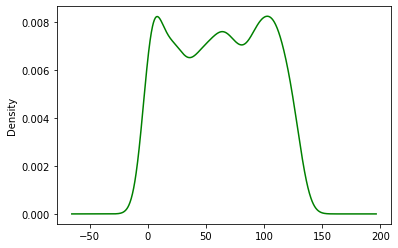

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

idx = pd.read_csv('drive/MyDrive/DL_Project/Train.csv',header=None)
idx.iloc[:,2].plot.density(color='green')
plt.show()